In [ ]:

!pip install yfinance

# import required libs
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# warning hataane ke liye
import warnings
warnings.filterwarnings("ignore")

# NIFTY 50 ka data - '^NSEI' is the ticker
# start date 2020, so we get enough data
ticker = '^NSEI'  # AAPL likhna ho toh 'AAPL'
start_date = '2020-01-01'
end_date = '2024-12-31'

# data extract thingy
df = yf.download(ticker, start=start_date, end=end_date)

# to check
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2020-01-01,12182.500000,12222.200195,12165.299805,12202.150391,304100
2020-01-02,12282.200195,12289.900391,12195.250000,12198.549805,407700
2020-01-03,12226.650391,12265.599609,12191.349609,12261.099609,428800
2020-01-06,11993.049805,12179.099609,11974.200195,12170.599609,396500
2020-01-07,12052.950195,12152.150391,12005.349609,12079.099609,447800


In [ ]:
# checking for missing/null values
print("Missing values in each column:")
print(df.isnull().sum())

# if missing values exist, we'll just forward fill them for now
# Forward fill: use previous day's value if today's is missing
df.ffill(inplace=True)

# resetting index so Date becomes a column instead of index
df.reset_index(inplace=True)

# just checking again if all clean now
print("\nAfter cleaning:")
print(df.isnull().sum())

# quick look at the structure
df.head()


Missing values in each column:
Price   Ticker
Close   ^NSEI     0
High    ^NSEI     0
Low     ^NSEI     0
Open    ^NSEI     0
Volume  ^NSEI     0
dtype: int64

After cleaning:
Price   Ticker
Date              0
Close   ^NSEI     0
High    ^NSEI     0
Low     ^NSEI     0
Open    ^NSEI     0
Volume  ^NSEI     0
dtype: int64


Price,Date,Close,High,Low,Open,Volume
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
0,2020-01-01,12182.500000,12222.200195,12165.299805,12202.150391,304100
1,2020-01-02,12282.200195,12289.900391,12195.250000,12198.549805,407700
2,2020-01-03,12226.650391,12265.599609,12191.349609,12261.099609,428800
3,2020-01-06,11993.049805,12179.099609,11974.200195,12170.599609,396500
4,2020-01-07,12052.950195,12152.150391,12005.349609,12079.099609,447800


In [ ]:
# flattening the column names
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# now df['Close'], df['Open'], etc. will work fine. nested cols error de sakta hai
df.head()


,Date,Close,High,Low,Open,Volume
0,2020-01-01,12182.500000,12222.200195,12165.299805,12202.150391,304100
1,2020-01-02,12282.200195,12289.900391,12195.250000,12198.549805,407700
2,2020-01-03,12226.650391,12265.599609,12191.349609,12261.099609,428800
3,2020-01-06,11993.049805,12179.099609,11974.200195,12170.599609,396500
4,2020-01-07,12052.950195,12152.150391,12005.349609,12079.099609,447800


In [ ]:
# SMA - simple moving average of closing price
# SMA 10 means average of past 10 days' Close prices

df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# EMA - exponential moving average, gives more weight to recent days. ye imp hai
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# shd come in the data now
df[['Date', 'Close', 'SMA_10', 'EMA_10']].tail(10)


,Date,Close,SMA_10,EMA_10
1226,2024-12-16,24668.250000,24616.690234,24563.056745
1227,2024-12-17,24336.000000,24604.575195,24521.773700
1228,2024-12-18,24198.849609,24577.715234,24463.060229
1229,2024-12-19,23951.699219,24502.045117,24370.085500
1230,2024-12-20,23587.500000,24393.015039,24227.797227
1231,2024-12-23,23753.449219,24306.459961,24141.552135
1232,2024-12-24,23727.650391,24218.219922,24066.297272
1233,2024-12-26,23750.199219,24129.059766,24008.824899
1234,2024-12-27,23813.400391,24055.529883,23973.293170
1235,2024-12-30,23644.900391,23943.189844,23913.585392


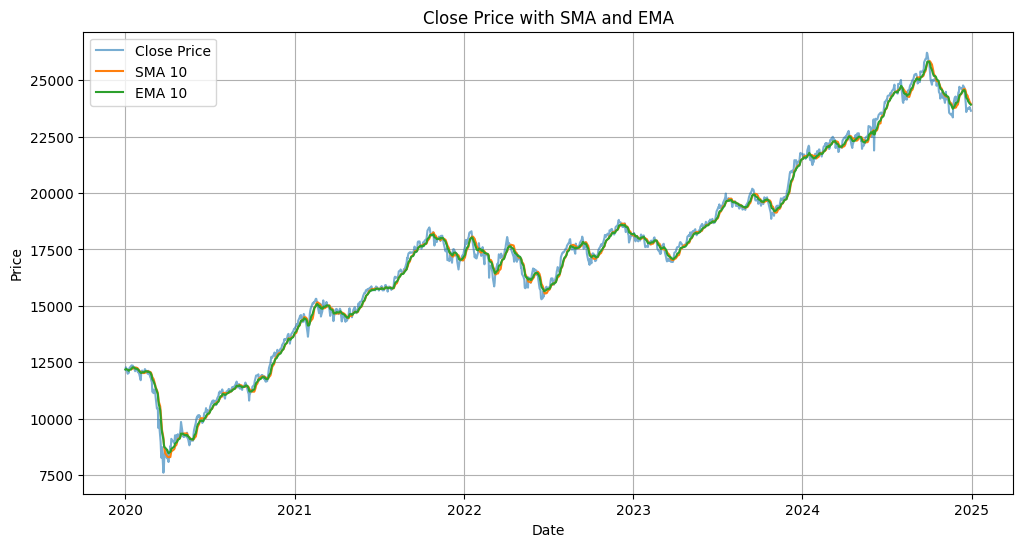

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.6)
plt.plot(df['Date'], df['SMA_10'], label='SMA 10')
plt.plot(df['Date'], df['EMA_10'], label='EMA 10')
plt.legend()
plt.title('Close Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [ ]:

# RSI = Relative Strength Index. Range: 0 to 100.
# overbought (>70) or oversold (<30) market ke liye indicator

def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI_14'] = compute_RSI(df['Close'])


# MACD = difference between 12 EMA and 26 EMA
# Signal line = 9-day EMA of MACD

ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()

df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()


# Bollinger Bands = SMA ± 2*std_dev
# BB width = (Upper - Lower) / SMA

sma_20 = df['Close'].rolling(window=20).mean()
std_20 = df['Close'].rolling(window=20).std()

upper_band = sma_20 + (2 * std_20)
lower_band = sma_20 - (2 * std_20)

df['BB_Width'] = (upper_band - lower_band) / sma_20  # relative width


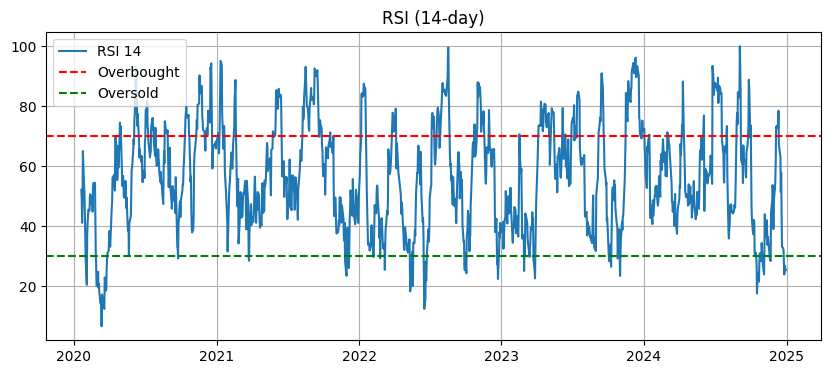

In [ ]:
# RSI plot
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['RSI_14'], label='RSI 14')
plt.axhline(70, color='r', linestyle='--', label='Overbought')
plt.axhline(30, color='g', linestyle='--', label='Oversold')
plt.title('RSI (14-day)')
plt.legend()
plt.grid(True)
plt.show()


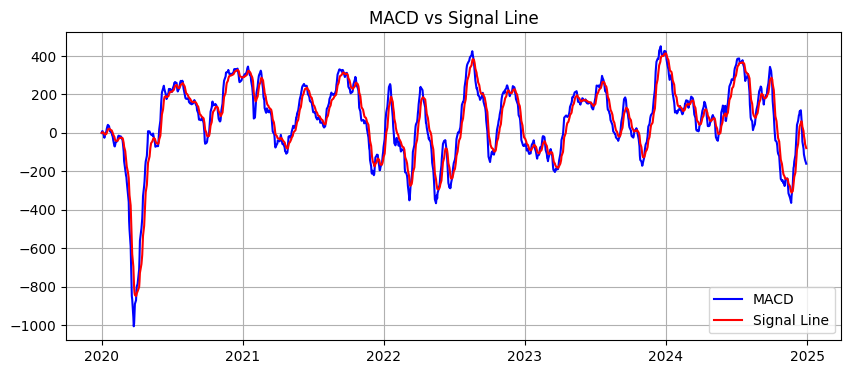

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['MACD'], label='MACD', color='b')
plt.plot(df['Date'], df['MACD_Signal'], label='Signal Line', color='r')
plt.title('MACD vs Signal Line')
plt.legend()
plt.grid(True)
plt.show()


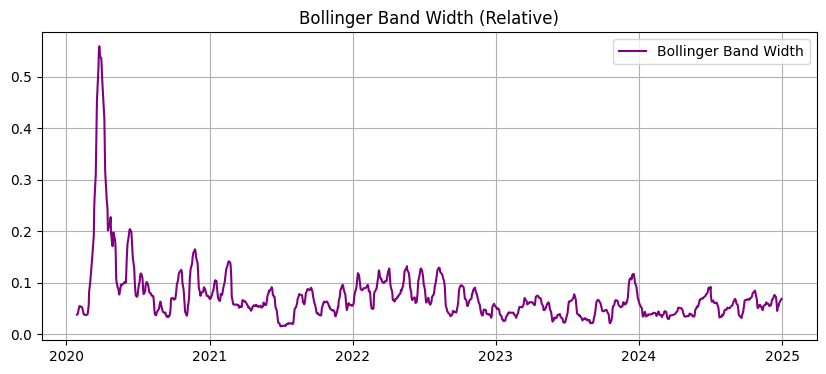

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['Date'], df['BB_Width'], label='Bollinger Band Width', color='purple')
plt.title('Bollinger Band Width (Relative)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# log returns = ln(Close_t / Close_t-1)
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# 5-day rolling volatility (std dev of log returns)
df['volatility_5d'] = df['log_return'].rolling(window=5).std()

# shift -5 so that today's row contains volatility of NEXT 5 days
df['target_volatility'] = df['volatility_5d'].shift(-5)

# output shd be okay for now
df[['Date', 'Close', 'log_return', 'target_volatility']].tail(10)


,Date,Close,log_return,target_volatility
1226,2024-12-16,24668.250000,-0.004048,0.008938
1227,2024-12-17,24336.000000,-0.013560,0.008577
1228,2024-12-18,24198.849609,-0.005652,0.008963
1229,2024-12-19,23951.699219,-0.010266,0.008461
1230,2024-12-20,23587.500000,-0.015322,0.005185
1231,2024-12-23,23753.449219,0.007011,NaN
1232,2024-12-24,23727.650391,-0.001087,NaN
1233,2024-12-26,23750.199219,0.000950,NaN
1234,2024-12-27,23813.400391,0.002658,NaN
1235,2024-12-30,23644.900391,-0.007101,NaN


In [ ]:
# Drop rows with any NaNs (especially from indicators + target)
df_model = df.dropna().copy()

# Step 2: Choose features you want to feed to model
# baadme jyada can be done but bahi ke liye thik hai
feature_cols = [
    'SMA_10', 'SMA_20',
    'EMA_10', 'EMA_20',
    'RSI_14',
    'MACD', 'MACD_Signal',
    'BB_Width',
    'Volume'
]

X = df_model[feature_cols]
y = df_model['target_volatility']

# Step 3: Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffle because time series
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (969, 9)
Test shape: (243, 9)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the model
model = LinearRegression()

# Train it (fit matlab learn from training data)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate how well it did
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print("MSE:", mse)
print("MAE:", mae)
print("R² Score:", r2)


Linear Regression Results:
MSE: 3.672429300554511e-05
MAE: 0.0037917354771453784
R² Score: -0.3156315696965404


In [ ]:
# since R² score for Linear Regression was low,
# trying Random Forest Regressor to see if it improves performance

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# initializing the RF model with 100 trees (n_estimators)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# training the model
rf_model.fit(X_train, y_train)

# predicting on test set
y_pred_rf = rf_model.predict(X_test)

# evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Results:")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("R² Score:", r2_rf)


Random Forest Regression Results:
MSE: 2.9946410968496668e-05
MAE: 0.0029930389561862794
R² Score: -0.07281694063687172


In [ ]:
# adding previous day's volatility as a feature (makes sense right? yesterday's vol may affect today's)
df_model['prev_volatility'] = df_model['target_volatility'].shift(1)


In [ ]:
# adding 'prev_volatility' to the features list
feature_cols.append('prev_volatility')


In [ ]:
X = df_model[feature_cols]
y = df_model['target_volatility']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [ ]:
print("New R² Score:", r2_score(y_test, y_pred_rf))


New R² Score: -0.07281694063687172


In [ ]:
# how much price varied intraday
df_model['high_low_diff'] = df_model['High'] - df_model['Low']

# whether price went up or down during the day
df_model['close_open_diff'] = df_model['Close'] - df_model['Open']

# how much it changed over the last 5 days
df_model['log_return_5d'] = np.log(df_model['Close'] / df_model['Close'].shift(5))


In [ ]:
feature_cols += ['high_low_diff', 'close_open_diff', 'log_return_5d']


In [ ]:
X = df_model[feature_cols]
y = df_model['target_volatility']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [ ]:
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("New R² Score:", r2_score(y_test, y_pred_rf))


New R² Score: 0.6190540114301628


In [ ]:
import pickle

# Save the model
with open('random_forest_volatility_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("✅ Model saved as random_forest_volatility_model.pkl")


✅ Model saved as random_forest_volatility_model.pkl


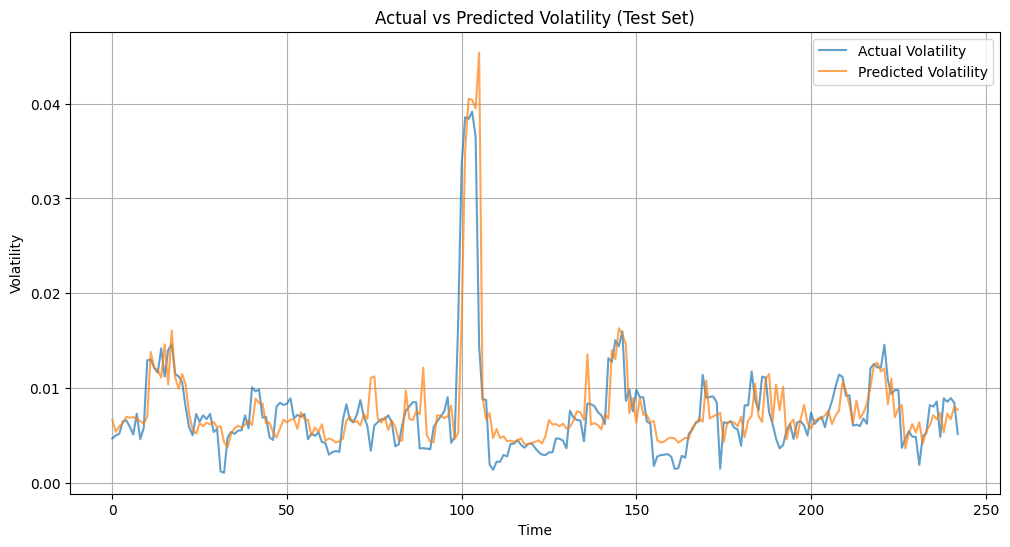

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Volatility', alpha=0.7)
plt.plot(y_pred_rf, label='Predicted Volatility', alpha=0.7)
plt.title('Actual vs Predicted Volatility (Test Set)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


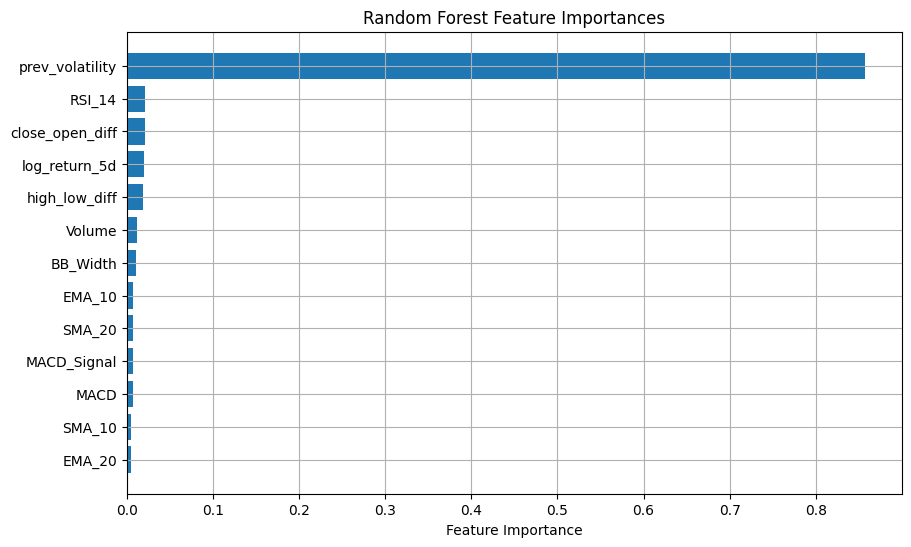

In [ ]:
importances = rf_model.feature_importances_
features = X.columns

# sort by importance
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances[sorted_idx], align='center')
plt.yticks(range(len(features)), features[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [ ]:
# convert pandas df to numpy arrays for manual calculations
X_np = X_train.values
y_np = y_train.values


In [ ]:
# manually add intercept column (bias term)
ones = np.ones((X_np.shape[0], 1))
X_np = np.hstack((ones, X_np))


In [ ]:
# normal equation
theta = np.linalg.inv(X_np.T @ X_np) @ X_np.T @ y_np



In [ ]:
# test set also needs 1s column for bias
X_test_np = X_test.values
X_test_np = np.hstack((np.ones((X_test_np.shape[0], 1)), X_test_np))

# prediction using matrix multiplication
y_pred_manual = X_test_np @ theta


In [ ]:
from sklearn.metrics import r2_score

r2_manual = r2_score(y_test, y_pred_manual)
print("Manual Linear Regression R² Score:", r2_manual)


ValueError: Input contains NaN.

In [ ]:
print("NaNs in y_test:", np.isnan(y_test).sum())
print("NaNs in y_pred_manual:", np.isnan(y_pred_manual).sum())



NaNs in y_test: 0
NaNs in y_pred_manual: 243


In [ ]:
print("NaNs in X_test_np:", np.isnan(X_test_np).sum())


NaNs in X_test_np: 0


In [ ]:
df_model = df_model.dropna().copy()


In [ ]:
# Recreate feature set and target
X = df_model[feature_cols]
y = df_model['target_volatility']

# Train/test split again
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Convert to NumPy for manual model
X_np = X_train.values
y_np = y_train.values
X_test_np = X_test.values

# Add 1s column (intercept)
X_np = np.hstack((np.ones((X_np.shape[0], 1)), X_np))
X_test_np = np.hstack((np.ones((X_test_np.shape[0], 1)), X_test_np))

# Calculate weights manually
theta = np.linalg.inv(X_np.T @ X_np) @ X_np.T @ y_np

# Predict manually
y_pred_manual = X_test_np @ theta


In [ ]:
from sklearn.metrics import r2_score
r2_manual = r2_score(y_test, y_pred_manual)
print("Manual Linear Regression R² Score:", r2_manual)


Manual Linear Regression R² Score: 0.7611827640346913


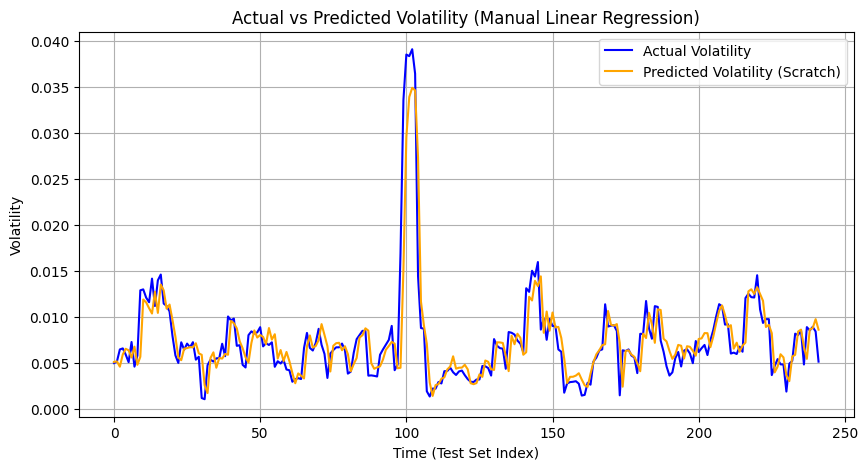

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Volatility', color='blue')
plt.plot(y_pred_manual, label='Predicted Volatility (Scratch)', color='orange')
plt.title('Actual vs Predicted Volatility (Manual Linear Regression)')
plt.xlabel('Time (Test Set Index)')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()
